In [1]:
import os
from shutil import copyfile
from random import sample
from keras import models, layers, optimizers, losses, metrics
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as viz

Using TensorFlow backend.


In [9]:
kaggle_dir = '.data/cats_vs_dogs_kaggle'
base_dir = '.data/cats_vs_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

num_train_samples = 1000
num_test_samples = 500

In [16]:
def make_dirs(*dirs):
    for dir_path in dirs:
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

def file_names(prefix=None, start=0, end=0, num_samples=0):
    for num in sample(range(start, end), k=num_samples):
        yield '{}.{}.jpg'.format(prefix, num)

def copy_files(names, src_dir='', dest_dir=''):
    counter = 0
    for filename in names:
        src = os.path.join(src_dir, filename)
        dest = os.path.join(dest_dir, '{}.jpg'.format(counter))
        copyfile(src, dest)
        counter += 1

In [2]:
# copy random 2000 images from Kaggle "Dogs vs Cats" dataset to training set,
# 1000 images to test and validation sets
# each set contains the same number of cats and dogs image samples

make_dirs(base_dir, train_dir, validation_dir, test_dir)
make_dirs(train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir)

copy_files(file_names(prefix='cat', start=0, end=6000, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_cats_dir)
copy_files(file_names(prefix='cat', start=6000, end=9000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_cats_dir)
copy_files(file_names(prefix='cat', start=9000, end=12000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_cats_dir)

copy_files(file_names(prefix='dog', start=0, end=6000, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_dogs_dir)
copy_files(file_names(prefix='dog', start=6000, end=9000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_dogs_dir)
copy_files(file_names(prefix='dog', start=9000, end=12000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_dogs_dir)

In [10]:
# data preprocessing

rescale_factor = 1.0 / 255
width = 150
height = 150
batch_size = 20
train_stream = ImageDataGenerator(rescale=rescale_factor).flow_from_directory(train_dir,
                                                                              target_size=(width, height),
                                                                              batch_size=batch_size,
                                                                              class_mode='binary')
# test later with validation_split argument for ImageDataGenerator
validation_stream = ImageDataGenerator(rescale=rescale_factor).flow_from_directory(validation_dir,
                                                                                   target_size=(width, height),
                                                                                   batch_size=batch_size,
                                                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
rgb = 3
learning_rate = 0.0001

def build_network():
    network = models.Sequential()
    network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, rgb)))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(64, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(128, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(128, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Flatten())
    network.add(layers.Dense(512, activation='relu'))
    network.add(layers.Dense(1, activation='sigmoid'))
    
    network.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                    loss=losses.binary_crossentropy,
                    metrics=[metrics.binary_accuracy])
    return network

In [12]:
convnet = build_network()
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [13]:
num_epochs = 200
history = convnet.fit_generator(train_stream,
                                steps_per_epoch=num_train_samples//batch_size,
                                epochs=num_epochs,
                                validation_data=validation_stream,
                                validation_steps=num_test_samples//batch_size).history

Epoch 1/200
50/50 [==============================] - 5s 100ms/step - loss: 0.6918 - binary_accuracy: 0.5240 - val_loss: 0.7041 - val_binary_accuracy: 0.5120
Epoch 2/200
50/50 [==============================] - 4s 71ms/step - loss: 0.6876 - binary_accuracy: 0.5380 - val_loss: 0.6818 - val_binary_accuracy: 0.5180
Epoch 3/200
50/50 [==============================] - 4s 71ms/step - loss: 0.6645 - binary_accuracy: 0.5950 - val_loss: 0.6678 - val_binary_accuracy: 0.5780
Epoch 4/200
50/50 [==============================] - 4s 71ms/step - loss: 0.6589 - binary_accuracy: 0.6010 - val_loss: 0.6480 - val_binary_accuracy: 0.6300
Epoch 5/200
50/50 [==============================] - 4s 72ms/step - loss: 0.6282 - binary_accuracy: 0.6570 - val_loss: 0.6222 - val_binary_accuracy: 0.6740
Epoch 6/200
50/50 [==============================] - 4s 71ms/step - loss: 0.6041 - binary_accuracy: 0.6660 - val_loss: 0.6118 - val_binary_accuracy: 0.6480
Epoch 7/200
50/50 [==============================] - 4s 71ms/st

50/50 [==============================] - 4s 73ms/step - loss: 0.0648 - binary_accuracy: 0.9830 - val_loss: 0.8270 - val_binary_accuracy: 0.7400
Epoch 54/200
50/50 [==============================] - 4s 72ms/step - loss: 0.0801 - binary_accuracy: 0.9770 - val_loss: 0.9509 - val_binary_accuracy: 0.7120
Epoch 55/200
50/50 [==============================] - 4s 73ms/step - loss: 0.0611 - binary_accuracy: 0.9870 - val_loss: 0.7842 - val_binary_accuracy: 0.7460
Epoch 56/200
50/50 [==============================] - 4s 72ms/step - loss: 0.0576 - binary_accuracy: 0.9830 - val_loss: 0.8806 - val_binary_accuracy: 0.7280
Epoch 57/200
50/50 [==============================] - 4s 71ms/step - loss: 0.0449 - binary_accuracy: 0.9860 - val_loss: 0.9024 - val_binary_accuracy: 0.7500
Epoch 58/200
50/50 [==============================] - 4s 73ms/step - loss: 0.0684 - binary_accuracy: 0.9800 - val_loss: 1.0052 - val_binary_accuracy: 0.7240
Epoch 59/200
50/50 [==============================] - 4s 72ms/step - lo

50/50 [==============================] - 4s 73ms/step - loss: 0.0117 - binary_accuracy: 0.9950 - val_loss: 1.4208 - val_binary_accuracy: 0.7780
Epoch 106/200
50/50 [==============================] - 4s 73ms/step - loss: 0.0089 - binary_accuracy: 0.9970 - val_loss: 1.8788 - val_binary_accuracy: 0.7260
Epoch 107/200
50/50 [==============================] - 4s 71ms/step - loss: 0.0025 - binary_accuracy: 1.0000 - val_loss: 1.6489 - val_binary_accuracy: 0.7280
Epoch 108/200
50/50 [==============================] - 4s 72ms/step - loss: 0.0096 - binary_accuracy: 0.9970 - val_loss: 2.0773 - val_binary_accuracy: 0.7140
Epoch 109/200
50/50 [==============================] - 4s 71ms/step - loss: 0.0034 - binary_accuracy: 0.9980 - val_loss: 1.6701 - val_binary_accuracy: 0.7480
Epoch 110/200
50/50 [==============================] - 4s 72ms/step - loss: 0.0081 - binary_accuracy: 0.9960 - val_loss: 1.7677 - val_binary_accuracy: 0.7340
Epoch 111/200
50/50 [==============================] - 4s 71ms/ste

50/50 [==============================] - 4s 72ms/step - loss: 1.9510e-04 - binary_accuracy: 1.0000 - val_loss: 2.3504 - val_binary_accuracy: 0.7280
Epoch 157/200
50/50 [==============================] - 4s 70ms/step - loss: 2.8795e-05 - binary_accuracy: 1.0000 - val_loss: 2.5237 - val_binary_accuracy: 0.7160
Epoch 158/200
50/50 [==============================] - 4s 72ms/step - loss: 0.0160 - binary_accuracy: 0.9960 - val_loss: 1.8536 - val_binary_accuracy: 0.7640
Epoch 159/200
50/50 [==============================] - 4s 71ms/step - loss: 6.6918e-04 - binary_accuracy: 1.0000 - val_loss: 2.1063 - val_binary_accuracy: 0.7340
Epoch 160/200
50/50 [==============================] - 4s 71ms/step - loss: 9.4807e-04 - binary_accuracy: 0.9990 - val_loss: 2.7451 - val_binary_accuracy: 0.6780
Epoch 161/200
50/50 [==============================] - 4s 72ms/step - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 2.2297 - val_binary_accuracy: 0.7160
Epoch 162/200
50/50 [=============================

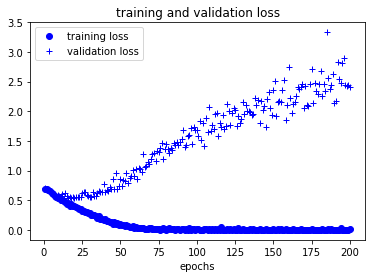

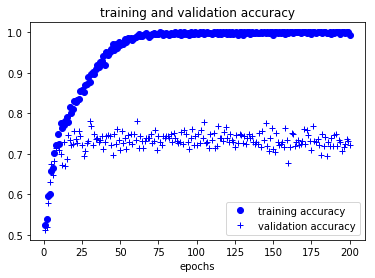

In [14]:
x = range(1, num_epochs + 1)

viz.plot(x, history['loss'], 'bo', label='training loss')
viz.plot(x, history['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()

In [18]:
# that's interesting
# let's make the training and validation sets as described in the book - no randomization, just take first n images

copy_files(file_names(prefix='cat', start=0, end=num_train_samples, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_cats_dir)
copy_files(file_names(prefix='cat', start=num_train_samples, end=num_train_samples + num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_cats_dir)
copy_files(file_names(prefix='cat', start=num_train_samples + num_test_samples, end=num_train_samples + 2 * num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_cats_dir)

copy_files(file_names(prefix='dog', start=0, end=num_train_samples, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_dogs_dir)
copy_files(file_names(prefix='dog', start=num_train_samples, end=num_train_samples + num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_dogs_dir)
copy_files(file_names(prefix='dog', start=num_train_samples + num_test_samples, end=num_train_samples + 2 * num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_dogs_dir)

In [19]:
convnet = build_network()

num_epochs = 30
history = convnet.fit_generator(train_stream,
                                steps_per_epoch=num_train_samples//batch_size,
                                epochs=num_epochs,
                                validation_data=validation_stream,
                                validation_steps=num_test_samples//batch_size).history

Epoch 1/30
50/50 [==============================] - 4s 88ms/step - loss: 0.6939 - binary_accuracy: 0.5000 - val_loss: 0.6865 - val_binary_accuracy: 0.6060
Epoch 2/30
50/50 [==============================] - 4s 73ms/step - loss: 0.6861 - binary_accuracy: 0.5460 - val_loss: 0.6820 - val_binary_accuracy: 0.5240
Epoch 3/30
50/50 [==============================] - 4s 72ms/step - loss: 0.6751 - binary_accuracy: 0.5890 - val_loss: 0.6691 - val_binary_accuracy: 0.5840
Epoch 4/30
50/50 [==============================] - 4s 73ms/step - loss: 0.6728 - binary_accuracy: 0.5800 - val_loss: 0.6578 - val_binary_accuracy: 0.6240
Epoch 5/30
50/50 [==============================] - 4s 72ms/step - loss: 0.6496 - binary_accuracy: 0.6130 - val_loss: 0.6634 - val_binary_accuracy: 0.5940
Epoch 6/30
50/50 [==============================] - 4s 70ms/step - loss: 0.6358 - binary_accuracy: 0.6380 - val_loss: 0.6267 - val_binary_accuracy: 0.6720
Epoch 7/30
50/50 [==============================] - 4s 72ms/step - los

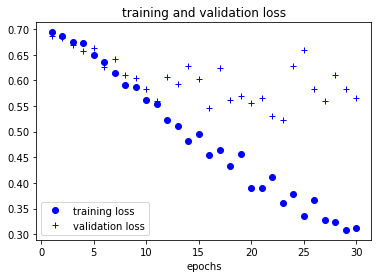

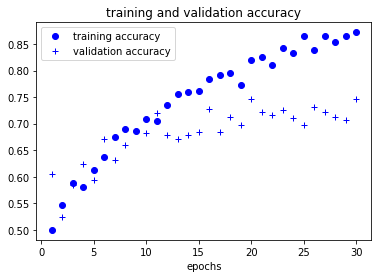

In [20]:
x = range(1, num_epochs + 1)

viz.plot(x, history['loss'], 'bo', label='training loss')
viz.plot(x, history['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()

In [21]:
# this is strange
# the graphs are different from the book even when the training/validation sets are the same

In [22]:
# use data augmentation
augmented_convnet = models.Sequential()
augmented_convnet.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, rgb)))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Conv2D(64, (3, 3), activation='relu'))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Conv2D(128, (3, 3), activation='relu'))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Conv2D(128, (3, 3), activation='relu'))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Flatten())
augmented_convnet.add(layers.Dropout(0.5))
augmented_convnet.add(layers.Dense(512, activation='relu'))
augmented_convnet.add(layers.Dense(1, activation='sigmoid'))
augmented_convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [23]:
augmented_convnet.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                          loss=losses.binary_crossentropy,
                          metrics=[metrics.binary_accuracy])

In [24]:
batch_size = 32

train_stream = ImageDataGenerator(rescale=rescale_factor,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True).flow_from_directory(train_dir,
                                                                            target_size=(width, height),
                                                                            batch_size=batch_size,
                                                                            class_mode='binary')
# test later with validation_split argument for ImageDataGenerator
validation_stream = ImageDataGenerator(rescale=rescale_factor).flow_from_directory(validation_dir,
                                                                                   target_size=(width, height),
                                                                                   batch_size=batch_size,
                                                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
num_epochs = 100
history = augmented_convnet.fit_generator(train_stream,
                                          steps_per_epoch=300,
                                          epochs=num_epochs,
                                          validation_data=validation_stream,
                                          validation_steps=150).history

Epoch 1/100
300/300 [==============================] - 69s 231ms/step - loss: 0.6765 - binary_accuracy: 0.5626 - val_loss: 0.6654 - val_binary_accuracy: 0.5840
Epoch 2/100
300/300 [==============================] - 68s 225ms/step - loss: 0.6299 - binary_accuracy: 0.6412 - val_loss: 0.6223 - val_binary_accuracy: 0.6419
Epoch 3/100
300/300 [==============================] - 67s 224ms/step - loss: 0.5973 - binary_accuracy: 0.6785 - val_loss: 0.5963 - val_binary_accuracy: 0.6506
Epoch 4/100
300/300 [==============================] - 68s 227ms/step - loss: 0.5801 - binary_accuracy: 0.6929 - val_loss: 0.5516 - val_binary_accuracy: 0.7192
Epoch 5/100
300/300 [==============================] - 68s 226ms/step - loss: 0.5598 - binary_accuracy: 0.7131 - val_loss: 0.5247 - val_binary_accuracy: 0.7235
Epoch 6/100
300/300 [==============================] - 67s 225ms/step - loss: 0.5475 - binary_accuracy: 0.7204 - val_loss: 0.5473 - val_binary_accuracy: 0.7278
Epoch 7/100
300/300 [===================

Epoch 52/100
300/300 [==============================] - 67s 224ms/step - loss: 0.2580 - binary_accuracy: 0.8952 - val_loss: 0.6455 - val_binary_accuracy: 0.7817
Epoch 53/100
300/300 [==============================] - 67s 225ms/step - loss: 0.2514 - binary_accuracy: 0.8925 - val_loss: 0.5876 - val_binary_accuracy: 0.7776
Epoch 54/100
300/300 [==============================] - 67s 223ms/step - loss: 0.2458 - binary_accuracy: 0.8992 - val_loss: 0.4200 - val_binary_accuracy: 0.8342
Epoch 55/100
300/300 [==============================] - 67s 223ms/step - loss: 0.2448 - binary_accuracy: 0.9004 - val_loss: 0.4118 - val_binary_accuracy: 0.8635
Epoch 56/100
300/300 [==============================] - 67s 224ms/step - loss: 0.2466 - binary_accuracy: 0.8937 - val_loss: 0.3991 - val_binary_accuracy: 0.8543
Epoch 57/100
300/300 [==============================] - 67s 223ms/step - loss: 0.2457 - binary_accuracy: 0.8985 - val_loss: 0.3930 - val_binary_accuracy: 0.8365
Epoch 58/100
300/300 [============

In [26]:
augmented_convnet.save('augmented_convnet_2.h5')

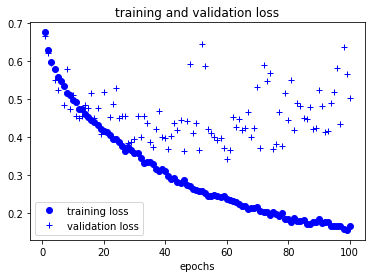

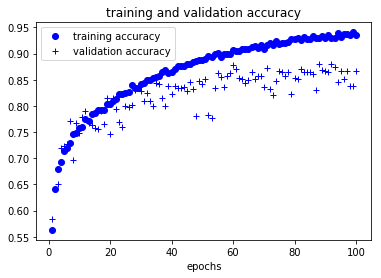

In [27]:
x = range(1, num_epochs + 1)

viz.plot(x, history['loss'], 'bo', label='training loss')
viz.plot(x, history['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()

In [ ]:
# this may happen because the learning rate is too high